# 문제 1 _RNN_ (50점)
(참고)
- 딥러닝으로 걷는 시계열 예측
- https://github.com/jeffheaton/app_deep_learning?tab=readme-ov-file#syllabus 강의의 Module 10: Time Series in PyTorch

In [1]:
import pandas as pd
import numpy as np
import copy

# Visualization
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import matplotlib
import seaborn as sns
%matplotlib inline

# PyTorch
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

#### 아래 코드를 실행해주세요. (파일 경로는 적절히 변경)

In [35]:
samsung = pd.read_csv('../../common_data/samsung.csv',encoding='cp949',index_col=0)
for i in range(len(samsung.index)):
    for j in range(len(samsung.iloc[i])):
        samsung.iloc[i,j] = int(samsung.iloc[i,j].replace(',',''))
samsung.head(5)

,시가,고가,저가,종가,거래량
일자,,,,,
2020-01-31,57800,58400,56400,56400,19749457
2020-01-30,58800,58800,56800,57200,20821939
2020-01-29,59100,59700,58800,59100,16446102
2020-01-28,59400,59400,58300,58800,23664541
2020-01-23,61800,61800,60700,60800,14916555


### 문제1-1) (6점)
samsung 데이터셋을 time series 데이터에 맞게 변형하여라.
- 시퀀스 길이 : sequence_size = 10
- output_size : 예측할 sequence의 길이 = 1

In [ ]:
SEQUENCE_SIZE = 10
def to_sequence(dataset, seq_size, output_size):
    dataset = dataset.values
    x,y = [],[]
    for i in range(len(dataset)):
        x_end_number = i + ???
        y_end_number = x_end_number + ???
        if y_end_number > len(dataset):
            break
        tmp_x = dataset[???]
        tmp_y = dataset[???]
        x.append(tmp_x)
        y.append(tmp_y)
    return np.array(x), np.array(y)

x,y = to_sequence(samsung, SEQUENCE_SIZE, 1)

x와 y의 shape을 확인해보세요

In [ ]:
print(x_train.shape, y_train.shape, sep='\n')

### 문제1-2) (1점)
train, test 데이터셋으로 분할하세요.
- test_size = 0.2
- random_state = 142

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = ???

### 문제1-3) (2점)
전처리를 위해 x_train과 x_test 데이터셋을 잠시 2차원으로 변형하여 StandarScaler로 표준화 해주세요.

In [ ]:
# Reshape
x_train_2d = np.reshape(x_train, ???)
x_test_2d = np.reshape(x_test, ???)

# Preprocessing
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = ???
x_test_scaled = ???

### 문제1-4) (1점)
전처리가 완료된 데이터를 다시 time series 데이터에 맞게 3차원으로 변형하세요.

In [ ]:
x_train = np.reshape(x_train_scaled, ???)
x_test = np.reshape(x_test_scaled, ???)

### 문제1-5) (10점)
RNN 모델을 정의하세요.<br>
RMSE 손실함수 클래스를 정의하세요.

In [ ]:
class RNNModel(nn.Module):
    def __init__(self,feature_size):
        super(RNNModel,self).__init__()
        self.rnn = nn.RNN(???, hidden_size=64, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.seq = nn.Sequential(nn.Linear(64,32),
                                nn.ReLU(),
                                nn.Linear(32,32),
                                nn.ReLU(),
                                nn.Linear(32,16),
                                nn.ReLU(),
                                nn.Linear(16,???)
                                )
        
    def forward(self,x):
        x,_ = self.rnn(x)
        x = self.dropout(x[???,???,???])
        x = self.seq(x)
        return x
    
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,pred,true):
        return ???
    
model = RNNModel(???) 
criterion = ???

In [48]:
#(문제 아님)
# optimizer 와 scheduler를 정의합니다. (코드 실행해주세요.)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=20,verbose=True)

### 문제1-6) (5점)
train-validation 셋을 준비하고, 
데이터셋을 tensor로 변환하고,
DataLoader에 담으세요.

In [ ]:
# split train dataset into train-validation (random_state=142,test_size=0.2)
x_tr, x_val, y_tr, y_val = ???

# to tensor
x_tr_tensor = torch.tensor(x_tr.astype(np.float32),dtype=torch.float32)
x_val_tensor = torch.tensor(x_val.astype(np.float32),dtype=torch.float32)
y_tr_tensor = torch.tensor(y_tr.astype(np.float32),dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.astype(np.float32),dtype=torch.float32)

# to DataLoader
batch_size = 30
train_loader = DataLoader(???,
                         batch_size=batch_size,shuffle=True)
val_loader = DataLoader(???,
                       batch_size=batch_size,shuffle=False)

In [50]:
#(문제 아님)
import copy
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
        elif self.best_loss - val_loss >= self.min_delta:
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_loss = val_loss
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
        else:
            self.counter += 1
            self.status = f"No improvement in the last {self.counter} epochs"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs."
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        return False

### 문제1-7) (20점)
모델을 훈련시키세요.

In [ ]:
EPOCHS = 1000
epoch_counter = 0
patience = 50
best_loss = float('inf')
done = False
es = EarlyStopping(patience=patience)
tr_losses_for_plot, val_losses_for_plot = [],[]

while not done and epoch_counter<EPOCHS:
    epoch_counter+=1
    
    # train
    model.train()
    train_losses = []
    for x_batch,y_batch in train_loader:
        ???
        ???
        ???
        ???
        ???
        train_losses.append(loss.item())
    train_loss = np.mean(train_losses)
    tr_losses_for_plot.append(train_loss)
    
    # validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            ???
            ???
            val_losses.append(loss.item())
    val_loss = np.mean(val_losses)
    val_losses_for_plot.append(val_loss)
    scheduler.step(val_loss)
    
    if es(model, val_loss):
        done = True
    
    # print each 10 epochs
    if epoch_counter % 10 == 0:
        print(f"Epoch {epoch_counter}/{EPOCHS}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

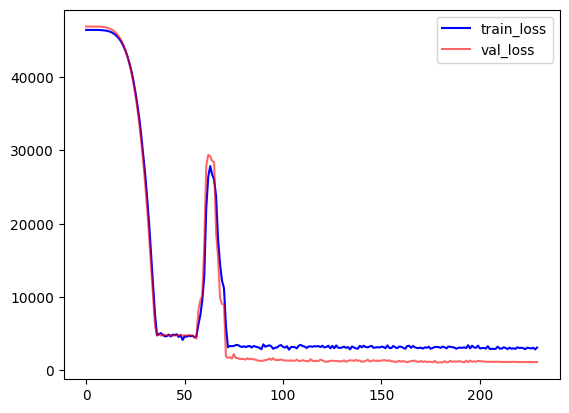

In [53]:
# (문제 아님)
import matplotlib.pyplot as plt
plt.plot(range(len(tr_losses_for_plot)),tr_losses_for_plot,color='blue',label='train_loss')
plt.plot(range(len(val_losses_for_plot)),val_losses_for_plot,color='red',label='val_loss',alpha=0.6)
plt.legend()
plt.show()

### 문제1-8) (5점)
테스트 데이터셋으로 예측을 진행하고 최종 결과를 확인하세요.<br>
아래 그래프처럼 나와야 합니다.

In [ ]:

# evaluation
model.???
with ???:
    x_test_tensor = torch.tensor(x_test.astype(np.float32),dtype=torch.float32)
    pred = ???

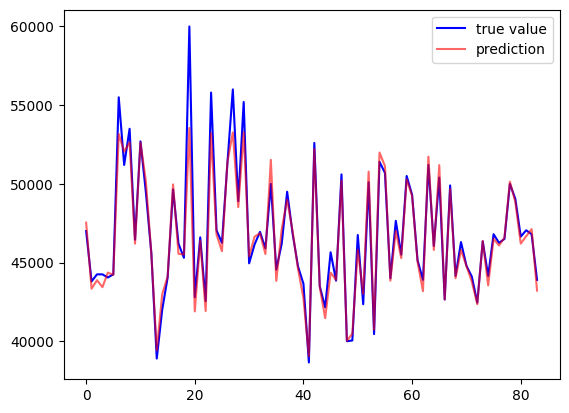

In [56]:
# (바로 실행하면 됩니다.)
pred_np = pred.detach().numpy()
r = len(np.reshape(y_test,(-1)))
plt.plot(list(range(r)),np.reshape(y_test,(-1)), color='blue', label='true value')
plt.plot(list(range(r)),np.reshape(pred_np,(-1)), color='red',alpha=0.6, label='prediction')
plt.legend()
plt.show()

## 2. Transformer 구현하기(50점)

아래 사진은 Transformer 모델의 전체적인 구조입니다.

해당 복습과제는 가능한 COLAB에서 '런타임' -> '런타임 유형 변경' -> 'GPU'로 설정 후 해결해주세요.

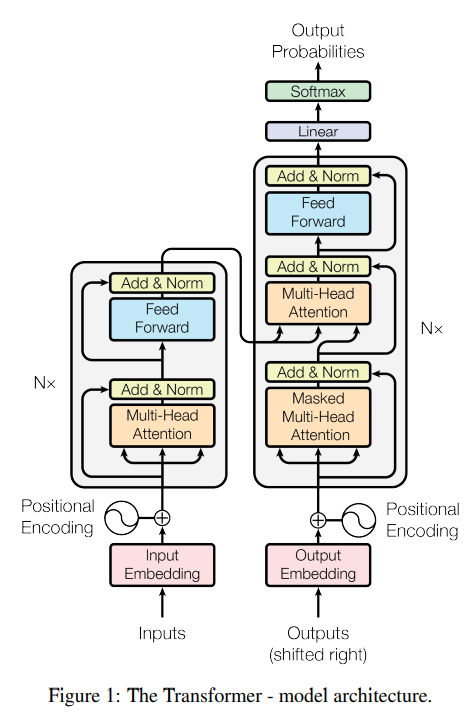

!!!!!아래 블로그를 참고하여 복습과제를 해결해주세요.

https://kaya-dev.tistory.com/8

https://kaya-dev.tistory.com/11


### 2-1 Positional Encoding

Transformer 모델은 input sentence를 한번에 모델에 집어넣기 때문에 모델에게 순서 정보를 알려줄 필요가 있고, 이를 위해 Positional Encoding을 사용합니다.

아래 코드의 '''YOURCODE1'''를 채워주세요.

In [ ]:
import torch
import torch.nn as nn

class PositionalEncoding(nn.Module):

    def __init__(self,max_len,d_model,device):
        super(PositionalEncoding,self).__init__()

        self.encoding = torch.zeros(max_len,d_model,device = device)
        self.encoding.requires_grad = False # we don't need to compute gradient

        pos = torch.arange(0,max_len,device=device)
        pos = pos.float().unsqueeze(dim = 1)

        _2i = '''YOURCODE1'''(0,d_model,step = 2,device = device).float()

        self.encoding[:,0::2] = torch.sin(pos/(10000**(_2i/d_model)))
        self.encoding[:,1::2] = torch.cos(pos/(10000**(_2i/d_model)))

    def forward(self,x):
        batch_size,seq_len = x.size()

        return self.encoding[:seq_len,:]

### 2-2 Multi-Head Attention

Multi-Head Attention은 문장의 특징 정보를 더 많이 잡을수 있게 도와줍니다.

아래 코드를 실행해 주세요.


In [ ]:
import math

class ScaleDotProductAttention(nn.Module):

    def __init__(self):
        super(ScaleDotProductAttention,self).__init__()
        self.softmax = nn.Softmax()

    def forward(self,q,k,v,mask = None, e = 1e-12):
        # input is 4 dimension tensor
        # [batch_size,head,length,d_tensor]
        batch_size,head,length,d_tensor = k.size()

        # 1. dot product Query with Key^T to compute similarity
        k_t = k.view(batch_size,head,d_tensor,length)
        score = (q @ k_t) / math.sqrt(d_tensor) # @연산은 np.matmul과 같은 역할

        # 2. applying masking(optional)
        if mask is not None:
            score = score.masked_fill(mask == 0 ,-e)

        # 3. pass tem softmax to make [0,1] range
        score = self.softmax(score)

        # 4. Multiply with Value
        v = score @ v

        return v, score

아래 코드의 '''YOURCODE2'''를 채워주세요.

In [ ]:
class MultiHeadAttention(nn.Module):

    def __init__(self,d_model,n_head):
        super(MultiHeadAttention,self).__init__()
        self.n_head = n_head
        self.attention = ScaleDotProductAttention()
        self.w_q = nn.Linear(d_model,d_model)
        self.w_k = nn.Linear(d_model,d_model)
        self.w_v = nn.Linear(d_model,d_model)
        self.w_concat = nn.Linear(d_model,d_model)

    def split(self,tensor):

        batch_size,length,d_model = tensor.size()

        d_tensor = d_model//self.n_head

        tensor = tensor.view(batch_size,self.n_head,length,d_tensor)

        return tensor

    def concat(self,tensor):

        batch_size,head,length,d_tensor = tensor.size()
        d_model = head*d_tensor

        tensor = tensor.view(batch_size,length,d_model)
        return tensor

    def forward(self,q,k,v,mask = None):

        #1. dot product with weight metrics
        q,k,v = self.w_q(q),self.w_k(k),self.w_v(v)

        # 2. split tensor by number of heads
        q,k,v = self.split(q),self.split(k),self.split(v)

        # 3. do scale dot product to compute similarity (attention 계산)
        out,attention = '''YOURCODE2'''

        # 4. concat and pass to linear layer
        out = self.concat(out)
        out = self.w_concat(out)

        return out

### 2-3 Add & Norm

Add & Norm은 Residuanl Connection과 Layer Normalization을 수행하는 단계입니다.

아래 코드의 '''YOURCODE3'''를 채워주세요.

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self,d_model,eps = 1e-12):
        super(LayerNorm,self).__init__()
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta = nn.Parameter(torch.zeros(d_model))
        self.eps = eps

    def forward(self,x):
        mean = x.mean(-1,keepdim = True)
        std = x.std(-1,keepdim = True)
        # '-1' means last dimension

        out = (x-mean)/(std + self.eps)
        out = self.gamma * out + '''YOURCODE3'''

        return out

### 2-4 Feed Forward

Feed Forward는 Transformer의 Encoder와 Decoder에 모두 사용하는 Sub Layer입니다.

아래 코드의 '''YOURCODE4'''를 채워주세요.

In [ ]:
class PositionwiseFeedForward(nn.Module):

    def __init__(self,d_model,hidden,drop_prob = 0.1):
        super(PositionwiseFeedForward,self).__init__()
        self.linear1 = nn.Linear(d_model,hidden)
        self.linear2 = nn.Linear(hidden,d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p = '''YOURCODE4''')

    def forward(self,x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

### 2-5 Encoder Layer

아래 코드의 '''YOURCODE5'''를 채워주세요.

In [ ]:
class EncoderLayer(nn.Module):

    def __init__(self,d_model,ffn_hidden,n_head,drop_prob):
        super(EncoderLayer,self).__init__()

        #Multi-Head Attention
        self.attention = MultiHeadAttention(d_model,n_head)

        #Layer Normalization(Multi-Head Attention ->)
        self.norm1 = LayerNorm(d_model = d_model)
        self.dropout1 = nn.Dropout(p = drop_prob)

        #Feed-Forward
        self.ffn = '''YOURCODE5'''(d_model = d_model,hidden = ffn_hidden,drop_prob = drop_prob)

        #Layer Normalization(FFN ->)
        self.norm2= LayerNorm(d_model = d_model)
        self.dropout2 = nn.Dropout(p=drop_prob)

    def forward(self,x,src_mask):
        _x = x

        #1. Compute Multi-Head Attention
        x = self.attention(q= x,k= x,v= x,mask = src_mask)

        #2. Compute add & norm
        x = self.norm1(x + _x)
        x = self.dropout1(x)

        # 3. Compute Feed-Forward Network
        _x = x
        x = self.ffn(x)

        # 4. Compute add & norm
        x = self.norm2(x + _x)
        x = self.dropout2(x)

        return x

### 2-6 Encoder

아래 코드의 '''YOURCODE6'''를 채워주세요.

In [ ]:
class Encoder(nn.Module):

    def __init__(self,enc_voc_size,max_len,d_model,ffn_hidden,n_head,n_layers,
                drop_prob,device):
        super().__init__()

        #Embedding
        self.embed = nn.Embedding(num_embeddings = len(kor_text.vocab),embedding_dim = d_model,padding_idx = 1)

        #Positional Encoding
        self.pe = PositionalEncoding(max_len = max_len,d_model = d_model,device = device)

        #Add Multi layers
        self.layers = nn.ModuleList([EncoderLayer(d_model = d_model,
                                                 ffn_hidden = ffn_hidden,
                                                 n_head = n_head,
                                                 drop_prob = drop_prob)
                                    for _ in range(n_layers)])

    def forward(self,x,src_mask):
    	#Compute Embedding
        x = self.emb(x) #sentence -> vector

        #Get Positional Encoding
        x_pe = self.pe(x)

        #Embedding + Positional Encoding
        x = '''YOURCODE6'''

        #Compute Encoder layers
        for layer in self.layers:
            x = layer(x,src_mask)

        #Return encoder output
        return x

### 2-7 Decoder Layer

아래 코드의 '''YOURCODE7'''를 채워주세요.

In [ ]:
class DecoderLayer(nn.Module):

    def __init__(self,d_model,ffn_hidden,n_head,drop_prob):
        super(DecoderLayer,self).__init__()

        #self attention(only Decoder input)
        self.self_attention = MultiHeadAttention(d_model = d_model,n_head = n_head)

        #layer normalization(first)
        self.norm1 = LayerNorm(d_model = d_model)
        #dropout(first)
        self.dropout1 = nn.Dropout(p=drop_prob)

        #attention(encoder + decoder)
        self.enc_dec_attention = MultiHeadAttention(d_model = d_model,n_head = n_head)

        #layer normalization(second)
        self.norm2 = LayerNorm(d_model = d_model)
        #dropout(second)
        self.dropout2 = nn.Dropout(p=drop_prob)

        #Feed-Forward
        self.ffn = PositionwiseFeedForward(d_model = d_model,hidden = ffn_hidden,
                                           drop_prob = drop_prob)
        #Layer normalization(third)
        self.norm3 = LayerNorm(d_model = d_model)
        #dropout(third)
        self.dropout3 = nn.Dropout(p= drop_prob)

    def forward(self,dec,enc,trg_mask,src_mask):

        _x = dec
        #Compute self-attention
        x = self.self_attention(q = dec,k = dec,v = dec,mask = trg_mask)

        #Compute add & norm
        x = self.norm1(x + _x)
        x=  self.dropout1(x)

        if enc is not None:  #encoder의 출력값이 있다면 (없으면 FFN으로 넘어감)
            _x = x

            #Compute encoder - decoder attention
            #Query(q) : decoder attention output
            #Key(k) : Encoder output
            #Value(v) : Encoder output
            x = self.'''YOURCODE7'''(q = x,k = enc,v = enc,mask = src_mask)

            #Compute add & norm
            x = self.norm2(x + _x)
            x = self.dropout2(x)

        _x = x

        #Compute FFN
        x = self.ffn(x)

        #Compute add & norm
        x = self.norm3(x + _x)
        x = self.dropout3(x)

        return x

### 2-8 Decoder

아래 코드의 '''YOURCODE8'''를 채워주세요.

In [ ]:
class Decoder(nn.Module):
    def __init__(self,dec_voc_size,max_len,d_model,ffn_hidden,n_head,n_layers,
                drop_prob,device):
        super().__init__()

        #Embedding
        self.embed = nn.Embedding(num_embeddings = len(eng_text.vocab),embedding_dim = d_model,padding_idx = 1)

        #Positional Encoding
        self.pe = PositionalEncoding(max_len = 50,d_model = d_model,device = 'cuda')

        #Add decoder layers
        self.layers = nn.ModuleList([DecoderLayer(d_model = d_model,
                                                 ffn_hidden = ffn_hidden,
                                                 n_head = n_head,
                                                 drop_prob = drop_prob)
                                    for _ in range(n_layers)])

        #Linear
        self.linear = nn.Linear(d_model,dec_voc_size)

    def forward(self,trg,src,trg_mask,src_mask):

        #Compute Embedding
        trg = self.embed(trg)

        #Get Positional Encoding
        trg_pe = self.pe(trg)

        #Embedding + Positional Encoding
        trg = '''YOURCODE8'''

        #Compute Decoder layers
        for layer in self.layers:
            trg = layer(trg,src,trg_mask,src_mask)

        #pass to LM head
        output = self.linear(trg)

        return output

### 2-9 Transformer

아래 코드의 '''YOURCODE9'''과 '''YOURCODE10'''를 채워주세요.

In [ ]:
class Transformer(nn.Module):

    def __init__(self,src_pad_idx,trg_pad_idx,trg_sos_idx,enc_voc_size,dec_voc_size,d_model,n_head,max_len,
                ffn_hidden,n_layers,drop_prob,device):
        super().__init__()
        #Get <PAD> idx
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.trg_sos_idx = trg_sos_idx

        #Encoder
        self.encoder = Encoder(enc_voc_size = enc_voc_size,
                              max_len = max_len,
                              d_model = d_model,
                              ffn_hidden = ffn_hidden,
                              n_head = n_head,
                              n_layers = n_layers,
                              drop_prob = drop_prob,
                              device = device)

        #Decoder
        self.decoder = Decoder(dec_voc_size = dec_voc_size,
                              max_len = max_len,
                              d_model = d_model,
                              ffn_hidden = ffn_hidden,
                              n_head = n_head,
                              n_layers = n_layers,
                              drop_prob = drop_prob,
                              device = device)
        self.device = device

    def make_pad_mask(self,q,k):

    	#Padding부분은 attention연산에서 제외해야하므로 mask를 씌워줘서 계산이 되지 않도록 한다.

        len_q,len_k = q.size(1),k.size(1)
        print(len_k)
        #batch_size x 1 x 1 x len_k
        k = k.ne(self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        print(k.shape)
        # batch_size x1 x len_1 x len_k
        k = k.repeat(1,1,len_q,1)

        #batch_size x 1 x len_q x 1
        q = q.ne(self.src_pad_idx).unsqueeze(1).unsqueeze(3)
        #batch_size x 1 x len_q x len_k
        q = q.repeat(1,1,1,len_k)

        mask = k & q

        return mask

    def make_no_peak_mask(self,q,k):

        #Decoder 부분에서 t번째 단어를 예측하기 위해 입력으로 t-1번째 단어까지 넣어야 하므로 나머지 부분을 masking처리 한다.
        #만약 t번째 단어를 예측하는데 이미 decoder에 t번째 단어가 들어간다면?? => 답을 이미 알고 있는 상황..
        #따라서 Seq2Seq 모델에서 처럼 t번째 단어를 예측하기 위해서 t-1번째 단어까지만 입력될 필요가 있음
        #(나머지 t,t+1,...,max_len)까지 단어는 t번째 단어를 예측하는데 전혀 필요하지 않음 => Masking!!
        len_q,len_k = q.size(1),k.size(1)

        #len_q x len_k (torch.tril = 하삼각행렬)
        mask = torch.tril(torch.ones(len_q,len_k)).type(torch.BoolTensor).to(self.device)

        return mask

    def forward(self,src,trg):

        #Get Mask
        src_mask = self.'''YOURCODE9'''(src,src)
        src_trg_mask = self.make_pad_mask(trg,src)
        trg_mask = self.make_pad_mask(trg,trg) * self.'''YOURCODE10'''(trg,trg)

        #Compute Encoder
        enc_src = self.encoder(src,src_mask)

        #Compute Decoder
        output = self.decoder(trg,enc_src,trg_mask,src_trg_mask)

        return output